<a href="https://colab.research.google.com/github/adriennebohlmann/DecisionTrees_on_Gravity/blob/main/gravDT02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt 

In [ ]:
gravd = pd.read_csv('/content/gdrive/MyDrive/gravity/gravd.csv')
gravd.columns

Index(['year', 'iso_o', 'iso_d', 'contig', 'comlang_off', 'distw', 'pop_o',
       'gdp_o', 'gdpcap_o', 'iso2_o', 'pop_d', 'gdp_d', 'gdpcap_d', 'iso2_d',
       'heg_d', 'conflict', 'indepdate', 'heg_o', 'col_to', 'col_fr',
       'col_hist', 'col_cur', 'sever', 'sib_conflict', 'gatt_o', 'gatt_d',
       'rta', 'comleg', 'comcur', 'acp_to_eu', 'gsp', 'eu_to_acp', 'gsp_rec',
       'flow', 'validmirror', 'family', 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

In [ ]:
gravd = gravd[['flow', 'distw'
                     , 'gdp_o', 'gdp_d'
                     , 'contig', 'comlang_off', 'col_hist'
                     , 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'
                     ]]
gravd.isna().sum()

flow              0
distw             0
gdp_o          2006
gdp_d          1606
contig            0
comlang_off       0
col_hist          0
isl_o             0
isl_d             0
lndl_o            0
lndl_d            0
dtype: int64

drop nans and show correalation

In [ ]:
gravd = gravd.dropna()
gravd.corr()

,flow,distw,gdp_o,gdp_d,contig,comlang_off,col_hist,isl_o,isl_d,lndl_o,lndl_d
flow,1.000000,-0.049890,0.167948,0.213254,0.148241,0.020537,0.044647,-0.004968,-0.006837,-0.028287,-0.027311
distw,-0.049890,1.000000,0.047489,0.048441,-0.206316,-0.072044,-0.043466,0.176368,0.166128,-0.091461,-0.095632
gdp_o,0.167948,0.047489,1.000000,-0.013492,-0.003589,0.002866,0.054973,0.005815,0.006266,-0.092983,0.014054
gdp_d,0.213254,0.048441,-0.013492,1.000000,-0.003612,0.002542,0.054800,0.006411,0.007017,0.011372,-0.091553
contig,0.148241,-0.206316,-0.003589,-0.003612,1.000000,0.110013,0.089646,-0.068270,-0.068126,0.037150,0.037822
comlang_off,0.020537,-0.072044,0.002866,0.002542,0.110013,1.000000,0.145083,0.117948,0.125097,-0.017339,-0.025740
col_hist,0.044647,-0.043466,0.054973,0.054800,0.089646,0.145083,1.000000,0.031037,0.031258,-0.024387,-0.023205
isl_o,-0.004968,0.176368,0.005815,0.006411,-0.068270,0.117948,0.031037,1.000000,0.019769,-0.234955,-0.015212
isl_d,-0.006837,0.166128,0.006266,0.007017,-0.068126,0.125097,0.031258,0.019769,1.000000,-0.017286,-0.230824
lndl_o,-0.028287,-0.091461,-0.092983,0.011372,0.037150,-0.017339,-0.024387,-0.234955,-0.017286,1.000000,-0.006014


sort data (only to check details on stratification)

In [ ]:
# gravd = gravd.sort_values('flow', ignore_index=True)

how many zero obs are in the data

In [ ]:
flow = np.array(gravd.flow.astype(np.float32)) #*1000  
print('of', len(flow), 'observations'
      , len(flow) - np.count_nonzero(flow), ' are zero ='
      , (len(flow) - np.count_nonzero(flow))/ len(flow)*100, '%')


of 26967 observations 6970  are zero = 25.846404865205624 %


# discrete representation of flow distribution
create bins for stratify in train-test-split

In [ ]:
#len(gravd)

In [ ]:
#bins = np.linspace(0, len(gravd), 20)
bins = np.geomspace(1, len(gravd), 100)
# with upscaled flow:
#bins = np.geomspace(start=1, stop=0.5*len(gravd), num=300)
flowZ = flow.copy()
flowZ = np.digitize(flow, bins)
# flowZ[26800:26967]

reformat

In [ ]:
# weighted geographical between origin and destination
distw = np.array(gravd.distw.astype(np.float32))

# GDP of origin
gdp_o = np.array(gravd.gdp_o.astype(np.float32))

# GDP of destination
gdp_d = np.array(gravd.gdp_d.astype(np.float32))

# Dummies 
# neighbourhood status between origin and destination
contig = np.array(gravd.contig.astype(np.int8))
# common official language of origin and destination
comlang_off = np.array(gravd.comlang_off.astype(np.int8))
# colonial ties between origin and destination
col_hist = np.array(gravd.col_hist.astype(np.int8))
# island
isl_o = np.array(gravd.isl_o.astype(np.int8))
isl_d = np.array(gravd.isl_d.astype(np.int8))
# landlocked
lndl_o = np.array(gravd.lndl_o.astype(np.int8))
lndl_d = np.array(gravd.lndl_d.astype(np.int8))

X = np.array([flowZ, distw, gdp_o, gdp_d
              , contig, comlang_off, col_hist
              , isl_o, isl_d, lndl_o, lndl_d
              ]).T


define class and some functions for convenience

In [ ]:
# class for data preparation
class prepare_data:
    def __init__(self):
        self.X = X.copy()
        self.y = flow.copy()
        
    # train test split and transform
    def tts(self, rnd = 42):
         # train test split stratify on binary zero trade
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X[:,1:11], self.y
                                                                                , random_state=(rnd)
                                                                                , test_size=0.2
                                                                                , stratify=(self.X[:,0])
                                                                                )
        
# plot feature importance 
def plot_feature_importance(model):
    n_features = len(data.X_train[0,:])
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), feature_names) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

# random repetition loop instead of cross validation
def rnd_val(estimator, cv=100):
    all_r2_test = []
    for i in range(cv):
        data.tts(rnd=None)
        estimator.fit(data.X_train, data.y_train)
        r2_test = estimator.score(data.X_test, data.y_test)
        all_r2_test.append(r2_test)
        print('R2 test:', r2_test)
        print('R2 train', estimator.score(data.X_train, data.y_train))
    print('mean R2 test:', np.mean(all_r2_test))

# get R2 for test and train data
def get_R2s(estimator):
    print('test R2:', estimator.score(data.X_test, data.y_test))
    print('train R2:', estimator.score(data.X_train, data.y_train))
    
# plot prediction against true values
def plt_y_pred(estimator):
    y_pred = estimator.predict(data.X_test)
    # plot feature importance
    plot_feature_importance(estimator)
    plt.show()
    # plot y against y^
    plt.scatter(y_pred, data.y_test, s = 3)
    plt.xlabel('prediced trade flow from test data')
    plt.ylabel('true trade flow from test data')
    plt.title('test vs predicted trade flow')
    plt.show()
    # plot y against y^ on log axes
    plt.loglog(y_pred, data.y_test, marker = 'o', markersize = 3, linestyle = '')
    plt.xlabel('prediced trade flow from test data')
    plt.ylabel('true trade flow from test data')
    plt.title('test vs predicted trade flow on log axes')
    plt.show()
    
def plt_error_hist(estimator):
  estimator.fit(data.X_train, data.y_train)
  # out-of-sample errors
  y_pred = estimator.predict(data.X_test)
  oos_errors = data.y_test - y_pred
  plt.hist(oos_errors, bins=100, log=True)
  plt.title('out-of-sample error distribution')
  plt.show()
  # within-sample errors
  y_pred_is = estimator.predict(data.X_train)
  is_errors = data.y_train - y_pred_is
  plt.hist(is_errors, bins=100, log=True)
  plt.title('within-sample error distribution')
  plt.show()

initialize data and train-test-split

In [ ]:
data = prepare_data()
data.tts()

retrieve feature names

In [ ]:
feature_names = gravd.columns[1:len(X[0,:])]
feature_names

Index(['distw', 'gdp_o', 'gdp_d', 'contig', 'comlang_off', 'col_hist', 'isl_o',
       'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

# Simple Decision Tree

test R2: 0.7395588842533327
train R2: 0.9327914104934447


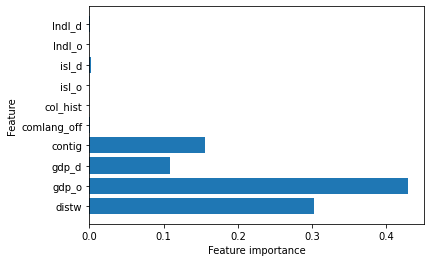

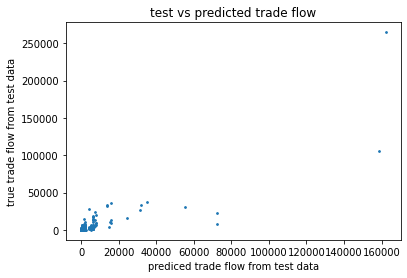

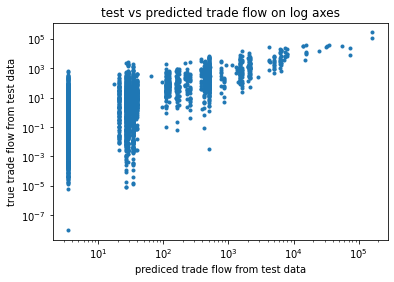

In [ ]:
tree = DecisionTreeRegressor(random_state=7, max_depth=7) 
tree.fit(data.X_train, data.y_train)

get_R2s(tree)
plt_y_pred(tree)

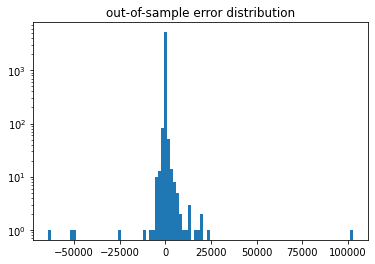

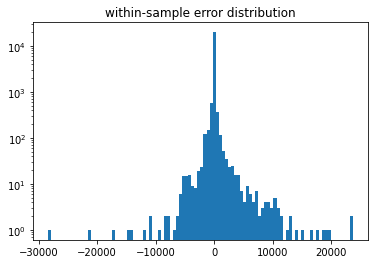

In [ ]:
plt_error_hist(tree)

In [ ]:
rnd_val(tree)

R2 test: 0.6170336111513448
R2 train 0.9568018606431027
R2 test: 0.43493741602606484
R2 train 0.9610923501162703
R2 test: 0.7492895984952765
R2 train 0.9417923789439704
R2 test: 0.31252713198009263
R2 train 0.9640606185192754
R2 test: 0.2629518387007148
R2 train 0.9603709893031956
R2 test: 0.5355593039678832
R2 train 0.9555205993459377
R2 test: 0.4433418197964652
R2 train 0.9529447409528207
R2 test: 0.48515066467623646
R2 train 0.9646824063518483
R2 test: 0.5055690102449659
R2 train 0.9484884104795449
R2 test: 0.7261505412145385
R2 train 0.9530918840624757
R2 test: 0.36791062161191157
R2 train 0.9540586756943364
R2 test: 0.4753763196025657
R2 train 0.9566486052883361
R2 test: 0.3435980428892367
R2 train 0.95521212479805
R2 test: 0.08998605119794123
R2 train 0.9439431859213111
R2 test: 0.26894057234355984
R2 train 0.960375455130924
R2 test: 0.38607979449865804
R2 train 0.9663093021551102
R2 test: 0.237299487006393
R2 train 0.9364718245729026
R2 test: 0.480739880950179
R2 train 0.9369548

grid search for one tree

In [ ]:
# criterion
crit = ['mse', 'friedman_mse', 'poisson']

# max depth
maxD = [2, 3, 5, 8, 13, 21, 34]

# create the grid
grid = {'criterion': crit, 'max_depth': maxD}

# base model to tune
baseTree = DecisionTreeRegressor()

# random grid search for parameters
tree_grid_search = GridSearchCV(estimator = baseTree
                                , param_grid= grid
                                , cv = 7              # no of cross validation
                                , n_jobs = -1         # use all available cores
                                )

for i in range(21):
    # if grid is to run on a different data split, run this:
    data.tts(rnd = None)
    # fixed data split:
    # data.tts(rnd = 42)
    # single grid search:
    tree_grid_search.fit(data.X_train, data.y_train)
    print(tree_grid_search.best_params_)

{'criterion': 'mse', 'max_depth': 8}
{'criterion': 'mse', 'max_depth': 2}
{'criterion': 'friedman_mse', 'max_depth': 34}
{'criterion': 'mse', 'max_depth': 34}
{'criterion': 'mse', 'max_depth': 21}
{'criterion': 'friedman_mse', 'max_depth': 13}
{'criterion': 'friedman_mse', 'max_depth': 13}
{'criterion': 'friedman_mse', 'max_depth': 13}
{'criterion': 'mse', 'max_depth': 5}
{'criterion': 'mse', 'max_depth': 13}
{'criterion': 'mse', 'max_depth': 34}
{'criterion': 'mse', 'max_depth': 5}
{'criterion': 'friedman_mse', 'max_depth': 34}
{'criterion': 'friedman_mse', 'max_depth': 8}
{'criterion': 'friedman_mse', 'max_depth': 8}
{'criterion': 'mse', 'max_depth': 13}
{'criterion': 'mse', 'max_depth': 21}
{'criterion': 'friedman_mse', 'max_depth': 21}
{'criterion': 'mse', 'max_depth': 13}
{'criterion': 'friedman_mse', 'max_depth': 13}
{'criterion': 'mse', 'max_depth': 21}


# Random Forest

test R2: 0.6756121837930711
train R2: 0.9364658888028049


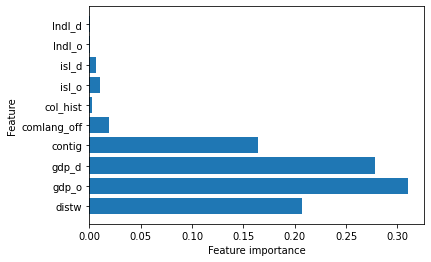

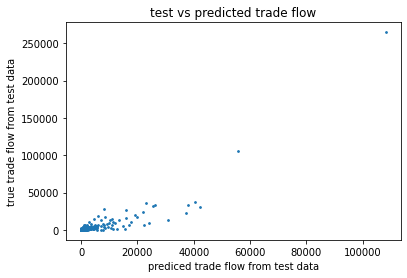

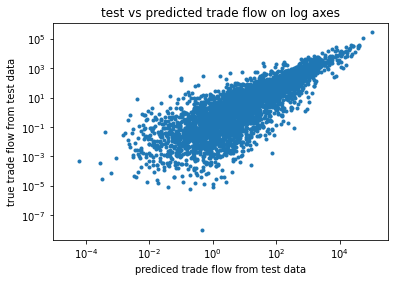

In [ ]:
data.tts()
forest = RandomForestRegressor(random_state=7) 
forest.fit(data.X_train, data.y_train)

get_R2s(forest)
plt_y_pred(forest)

In [ ]:
forest_opt = RandomForestRegressor(n_estimators=59, max_depth=52)
rnd_val(forest_opt)

R2 test: 0.5235098839194365
R2 train 0.9449077163606213
R2 test: 0.4574907361178712
R2 train 0.9499028539525585
R2 test: 0.6405755194068483
R2 train 0.9257831754737988
R2 test: 0.6600492650031601
R2 train 0.9397107200243169
R2 test: 0.732247813664533
R2 train 0.9415767190450841
R2 test: 0.6372144857702045
R2 train 0.9332442696764701
R2 test: 0.6899139498375202
R2 train 0.9498964035203988
R2 test: 0.6752128492155983
R2 train 0.9509118696041002
R2 test: 0.6939232283750563
R2 train 0.9420885399428155
R2 test: 0.7160384227130593
R2 train 0.9447731076730194
R2 test: 0.5588221597354446
R2 train 0.9475350585304425
R2 test: 0.7314019565141351
R2 train 0.9399245280072328
R2 test: 0.4759484314216271
R2 train 0.946628460985293
R2 test: 0.6551400811383294
R2 train 0.9061633032002699
R2 test: 0.7716356260503946
R2 train 0.9546907708377481
R2 test: 0.6546025234500503
R2 train 0.9607758858139109
R2 test: 0.7073673961926141
R2 train 0.9474055776183485
R2 test: 0.5547184831135454
R2 train 0.93810255776

random grid search for random forest

In [ ]:
# no. of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
# max levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)

# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               }

# base model to tune
baseForest = RandomForestRegressor()
# random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = baseForest
                               , param_distributions = random_grid
                               , n_iter = 100, cv = 3, verbose=2
                               #, random_state=42
                               , n_jobs = -1)

# if grid is to run on a different data split, run this:
data.tts(rnd = None)
# fixed data split:
#data.tts(rnd = 42)

# single grid search:
rf_random.fit(data.X_train, data.y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 53.6min finished


{'max_depth': 76, 'n_estimators': 86}

In [ ]:
forest_opt = RandomForestRegressor(n_estimators=377, max_depth=13)
rnd_val(forest_opt)

R2 test: 0.5801315753780065
R2 train 0.9512462870043583
R2 test: 0.7535991897006895
R2 train 0.9414071223150008
R2 test: 0.6293129331213545
R2 train 0.948511919301278
R2 test: 0.5605796572408259
R2 train 0.9594975756523016
R2 test: 0.636497128529293
R2 train 0.9463063924883115
R2 test: 0.7470044310412374
R2 train 0.9562804437469578
R2 test: 0.7364351838609807
R2 train 0.9504606480753958
R2 test: 0.5240218852921729
R2 train 0.9442568808951834
R2 test: 0.6150094082822655
R2 train 0.9466349854940962
R2 test: 0.675212963281651
R2 train 0.9416246249836978
R2 test: 0.5834885510787475
R2 train 0.9394743025548743
R2 test: 0.7166422330425961
R2 train 0.9432070727815771
R2 test: 0.7641926627909466
R2 train 0.9407523021059435
R2 test: 0.6375233717458788
R2 train 0.9535893403496956
R2 test: 0.6585040504949754
R2 train 0.9436179653091585
R2 test: 0.29426162482524254
R2 train 0.9572238884546292
R2 test: 0.6761099127879119
R2 train 0.9481653877211518
R2 test: 0.7106317697954172
R2 train 0.94444834656

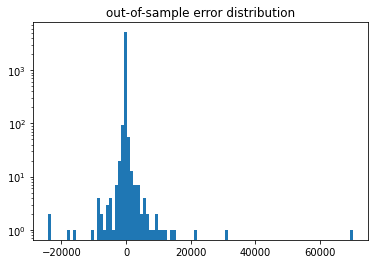

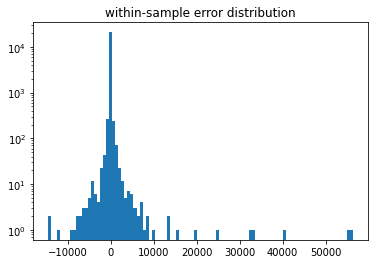

In [ ]:
plt_error_hist(forest_opt)

# Gradient Booster

test R2: 0.7437957469661448
train R2: 0.9357488921897997


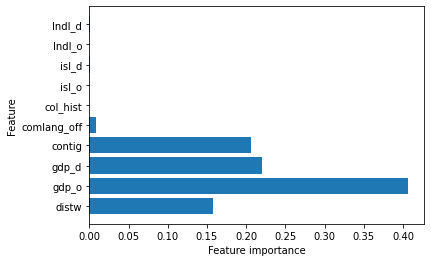

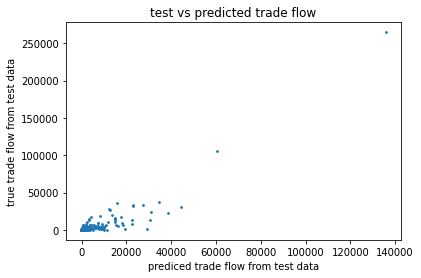

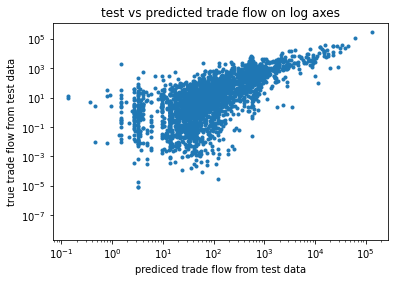

In [ ]:
data.tts()
booster = GradientBoostingRegressor(random_state=7)
booster.fit(data.X_train, data.y_train)

get_R2s(booster)
plt_y_pred(booster)

grid search for the gradient booster

In [ ]:
# loss
loss = ['ls', 'lad', 'huber', 'quantile']
# learning rate
lr = [0.001, 0.01, 0.1, 1]
# max depth
maxD = [2, 3, 5]

# create the random grid
random_grid = {'loss': loss
               , 'learning_rate': lr
               , 'max_depth': maxD
               }

# base model to tune
baseBoost = GradientBoostingRegressor()

# random grid search for parameters
boost_random = RandomizedSearchCV(estimator = baseBoost
                                  , param_distributions = random_grid
                                  , n_iter =10           # different combinations to search
                                  , cv = 3               # 3 fold cross validation
                                  )

# if grid is to run on a different data split, run this:
data.tts(rnd = None)
# fixed data split:
# data.tts(rnd = 42)

# single grid search:
boost_random.fit(data.X_train, data.y_train)
boost_random.best_params_

{'learning_rate': 1, 'loss': 'huber', 'max_depth': 2}

In [ ]:
booster_opt = GradientBoostingRegressor(learning_rate=0.1   
                                        , loss = 'ls'          
                                        , max_depth = 3         
                                        , n_estimators = 200
                                        )

rnd_val(booster_opt)

R2 test: 0.45532496155723046
R2 train 0.9489453514274889
R2 test: 0.8276302867178427
R2 train 0.9666227511709168
R2 test: 0.7749750085213584
R2 train 0.9600063915195177
R2 test: 0.7414109580724695
R2 train 0.9608117029202727
R2 test: 0.6437116325170633
R2 train 0.9716506593129769
R2 test: 0.26147225819536857
R2 train 0.9722984354924782
R2 test: 0.5833417401013898
R2 train 0.9707229168290276
R2 test: 0.5957244407646287
R2 train 0.9737825377457694
R2 test: 0.5647409813811375
R2 train 0.9708743797040242
R2 test: 0.8225887147335665
R2 train 0.9582614200217096
R2 test: 0.8560762069960499
R2 train 0.9692150417088923
R2 test: 0.414354337592323
R2 train 0.9714505353422418
R2 test: 0.7376485983280814
R2 train 0.97126487981723
R2 test: 0.7509028403331732
R2 train 0.966873511662962
R2 test: 0.8430194047811512
R2 train 0.9595001158319082
R2 test: 0.8126199030739486
R2 train 0.9694332960123512
R2 test: 0.7369656481934228
R2 train 0.9687745440861285
R2 test: 0.7640728904707291
R2 train 0.97129864676

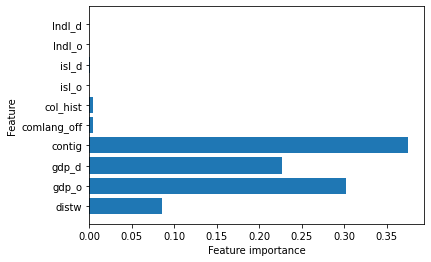

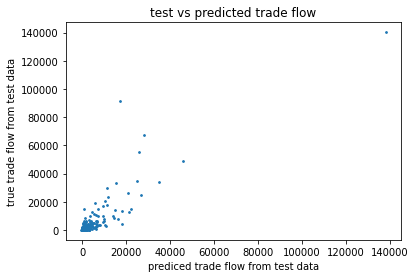

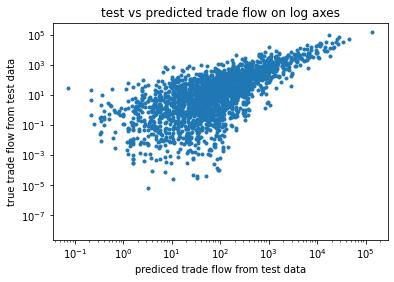

In [ ]:
plt_y_pred(booster_opt)

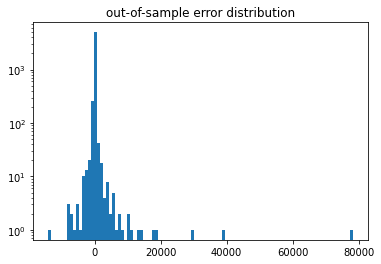

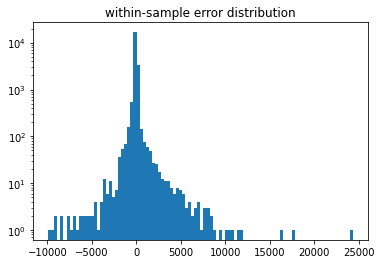

In [ ]:
plt_error_hist(booster_opt)

# Stochastic Gradient Boosting Regressor

test R2: 0.8512322213054507
train R2: 0.9905828201636379


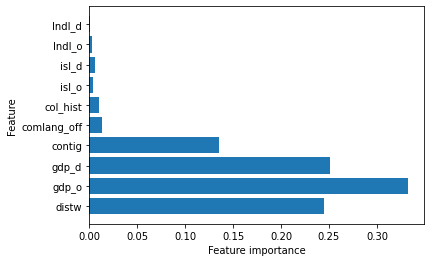

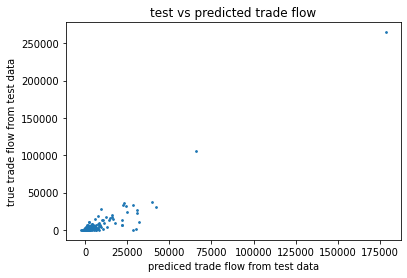

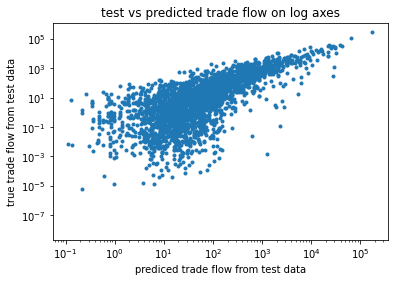

In [ ]:
data.tts() 
booster_SG = GradientBoostingRegressor(random_state=7
                                        , subsample = 0.5
                                        , max_depth=5       
                                        , n_estimators = 200
                                        ) 
     
booster_SG.fit(data.X_train, data.y_train)

get_R2s(booster_SG)
plt_y_pred(booster_SG)

grid search for stochastic gradient boosting regressor

In [ ]:
# loss
loss = ['ls', 'lad', 'huber', 'quantile']
# learning rate
lr = [0.01, 0.1]
# max depth
maxD = [3, 5, 7]
# estimators
n_estim = [200, 500, 1000]

# create the grid
grid = {'loss': loss
        , 'learning_rate': lr
        , 'max_depth': maxD
        , 'n_estimators' : n_estim
        }

# base model to tune
baseSGBoost = GradientBoostingRegressor(subsample = 0.5)

# random grid search for parameters
boost_search = GridSearchCV(estimator = baseSGBoost, param_grid = grid)
#boost_search = RandomizedSearchCV(estimator = baseSGBoost
#                                  , param_distributions = grid
#                                  , n_iter =100           # different combinations to search
#                                  , cv = 3              # 3 fold cross validation
#                                  )

# if grid is to run on a different data split, run this:
data.tts(rnd = None)
# fixed data split:
# data.tts(rnd = 42)

# single grid search:
boost_search.fit(data.X_train, data.y_train)
boost_search.best_params_

{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 7, 'n_estimators': 1000}

In [ ]:
booster_SG_opt_grid = GradientBoostingRegressor(subsample = 0.5
                                           , max_depth=7       
                                           , n_estimators = 1000
                                           , loss = 'huber'
                                            ) # 
rnd_val(booster_SG_opt_grid)

R2 test: 0.8775675691104576
R2 train 0.9937997837285317
R2 test: 0.7016862744165089
R2 train 0.9950097549723774
R2 test: 0.8844707721581384
R2 train 0.9921916021046637
R2 test: 0.7759118193946077
R2 train 0.9957085193345702
R2 test: 0.7739705362180487
R2 train 0.9933841830207589
R2 test: 0.847165247062561
R2 train 0.9942868757825165
R2 test: 0.7162599402513066
R2 train 0.9930097435158014
R2 test: 0.8490603648373569
R2 train 0.9951741592758141
R2 test: 0.4553291083438363
R2 train 0.9976506947399152
R2 test: 0.4892846125134126
R2 train 0.994334040617887
R2 test: 0.9091048706609169
R2 train 0.9945474568115076
R2 test: 0.6260039136764052
R2 train 0.9962186806088109
R2 test: 0.9207746049097341
R2 train 0.9952534712694642
R2 test: 0.810849132672609
R2 train 0.9942474978892646
R2 test: 0.7691630171246157
R2 train 0.9968718013197368
R2 test: 0.7616605992620654
R2 train 0.9965670432805265
R2 test: 0.5287243816557256
R2 train 0.987196828989511
R2 test: 0.7065617751777113
R2 train 0.9928571828111

In [ ]:
booster_SG_opt = GradientBoostingRegressor(subsample = 0.5
                                           , max_depth=5       
                                           , n_estimators = 200
                                            ) # 
rnd_val(booster_SG_opt)

R2 test: 0.3445033888033039
R2 train 0.9910631122681031
R2 test: 0.8770362682394481
R2 train 0.9930444408289166
R2 test: 0.7170232732112858
R2 train 0.9926514394712871
R2 test: 0.886631921190569
R2 train 0.9929423382759177
R2 test: 0.42863688829458807
R2 train 0.9896951730054735
R2 test: 0.6104031942433513
R2 train 0.9930944300045018
R2 test: 0.8102458660069469
R2 train 0.9894509116379794
R2 test: 0.8471669631998757
R2 train 0.9917233091245206
R2 test: 0.769330598511588
R2 train 0.9906936842676407
R2 test: 0.7411174738868986
R2 train 0.9934593894172029
R2 test: 0.8443590316640595
R2 train 0.9910061582899135
R2 test: 0.562319977929056
R2 train 0.9939216341575492
R2 test: 0.8188075739741794
R2 train 0.9929562418145302
R2 test: 0.7813719792318493
R2 train 0.993575263274609
R2 test: 0.7608258008406344
R2 train 0.9930920834425725
R2 test: 0.7391409628139343
R2 train 0.9936423284127022
R2 test: 0.6743478862482781
R2 train 0.9935003830923393
R2 test: 0.700889344452723
R2 train 0.9930317319332

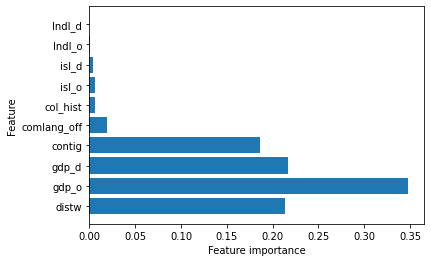

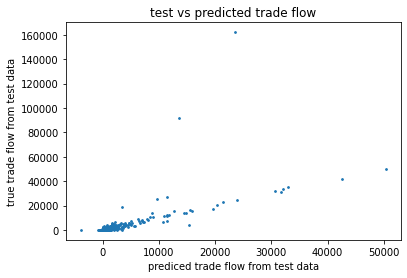

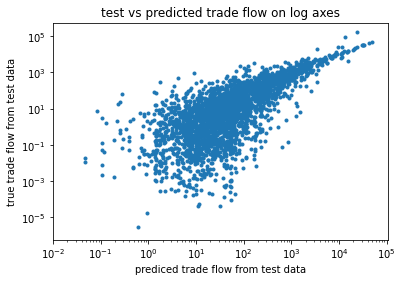

In [ ]:
 plt_y_pred(booster_SG_opt)

# Ada Boost

test R2: 0.6190297773137095
train R2: 0.6192623487683989


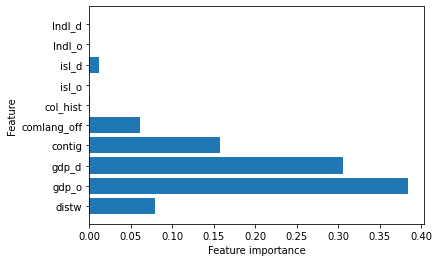

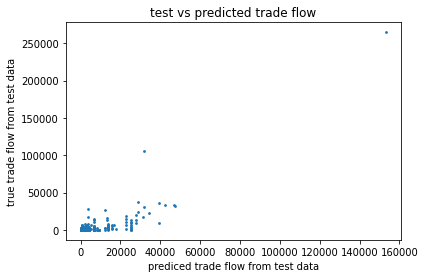

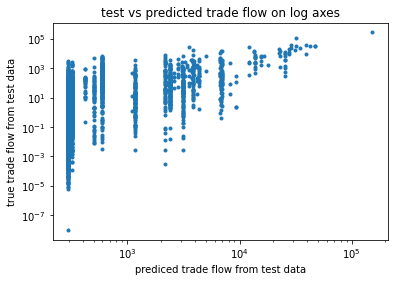

In [ ]:
data.tts() 
ada = AdaBoostRegressor()
     
ada.fit(data.X_train, data.y_train)

get_R2s(ada)
plt_y_pred(ada)

In [ ]:
# learning rate
lr = [0.01, 0.1, 1]
# loss
loss = ['linear', 'square', 'exponential']
# estimators
n_estim = [50, 100, 500]

# create the grid
grid = {'learning_rate': lr
        , 'loss': loss
        , 'n_estimators' : n_estim
        }

# base model to tune
baseAda = AdaBoostRegressor()

# random grid search for parameters
ada_search = GridSearchCV(estimator = baseAda, param_grid = grid)
#boost_search = RandomizedSearchCV(estimator = baseSGBoost
#                                  , param_distributions = grid
#                                  , n_iter =100           # different combinations to search
#                                  , cv = 3              # 3 fold cross validation
#                                  )

# if grid is to run on a different data split, run this:
data.tts(rnd = None)
# fixed data split:
# data.tts(rnd = 42)

# single grid search:
ada_search.fit(data.X_train, data.y_train)
ada_search.best_params_

{'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 50}

In [ ]:
ada_opt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), learning_rate=0.1, loss='square', n_estimators=200)
rnd_val(ada_opt)

R2 test: 0.5136643785475418
R2 train 0.9472970734089774
R2 test: 0.42461967877337653
R2 train 0.9446240493623992
R2 test: 0.5886609250901942
R2 train 0.9303431697558304
R2 test: 0.5223033942834883
R2 train 0.9490389751735433
R2 test: 0.41693717276045816
R2 train 0.9482245965243233
R2 test: 0.24855667758966193
R2 train 0.9270018618645788
R2 test: 0.8514047081796847
R2 train 0.9404592739439043
R2 test: 0.701245004871942
R2 train 0.9269550734762536
R2 test: 0.546633031291514
R2 train 0.9450702658760858
R2 test: 0.7791383250664237
R2 train 0.9252820190169938
R2 test: 0.48542874848147627
R2 train 0.9541085694424474
R2 test: 0.7071825051553579
R2 train 0.9400195563131977
R2 test: 0.7199891404853576
R2 train 0.9370777959541924
R2 test: 0.4036951356406068
R2 train 0.949443333129123
R2 test: 0.5372775180460132
R2 train 0.9521173904620817
R2 test: 0.7159476576189603
R2 train 0.9109757835636505
R2 test: 0.8392280986974963
R2 train 0.9125119892268695
R2 test: 0.4947374516544586
R2 train 0.94702669

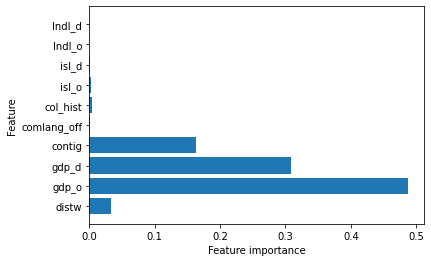

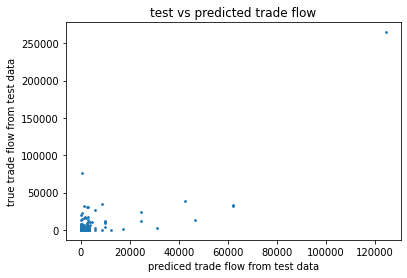

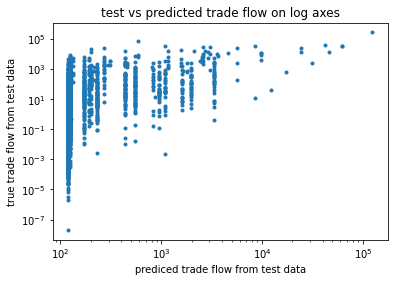

In [ ]:
plt_y_pred(ada_opt)

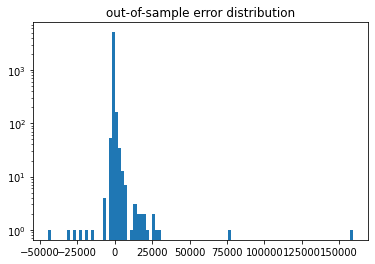

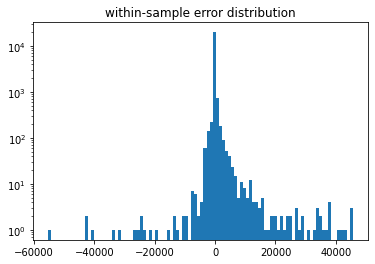

In [ ]:
plt_error_hist(ada_opt)